This example was adapted from skaae's Lasagne [recipe](https://github.com/skaae/Recipes/blob/spatial_transform/examples/spatial_transformer_network.ipynb).  
You can download skaae's Cluttered MNIST dataset [here](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz).

Reference at [arXiv](http://arxiv.org/abs/1506.02025)

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import theano
np.random.seed(1337)  # for reproducibility

from scipy.misc import imresize

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

from seya.layers.attention import SpatialTransformer#, ST2

batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "../../cluttered_saccades/mnist_cluttered_60x60_6distortions.npz"

Using Theano backend.


In [2]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))

y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))

input_shape = X_train.shape[1:]

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


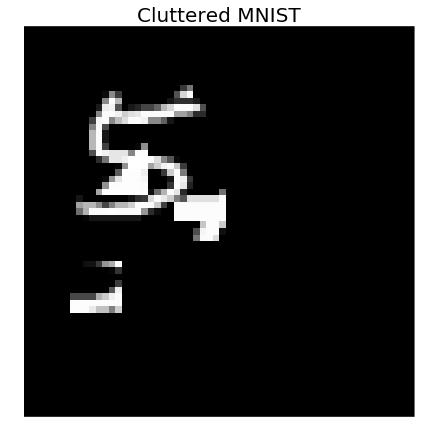

In [3]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [4]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [5]:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
locnet.add(Convolution2D(20, 5, 5))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, 5, 5))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))

In [6]:
model = Sequential()

model.add(SpatialTransformer(localization_net=locnet,
                             downsample_factor=3, input_shape=input_shape))

model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
input_shape

(1, 60, 60)

In [8]:
XX = model.input
YY = model.layers[0].output
F = theano.function([XX], YY)

In [ ]:
nb_epochs = 100 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()
scorev = np.zeros((nb_epochs))
scoret = np.zeros((nb_epochs))
try:
    for e in range(nb_epochs):
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(X_train.shape[0]/batch_size):
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scorev[e] = model.evaluate(X_valid, y_valid, verbose=0)[1]
        scoret[e] = model.evaluate(X_test, y_test, verbose=0)[1]
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev[e], scoret[e]))
        if e > 0 and scorev[e] > np.amax(scorev[0:e]):
            model.save_weights('STN_net_weights.h5', overwrite=True)
            print('Saving weights...')
        if e % 5 == 0:
            Xresult = F(X_batch[:9])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                plt.imshow(Xresult[i, 0], cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
except KeyboardInterrupt:
    pass

----------------------------------------


### Visualizing what the Spatial Transformer learned

In [10]:
model.load_weights('STN_net_weights.h5')

In [11]:
Xaug = X_train[:9]
Xresult = F(Xaug.astype('float32'))

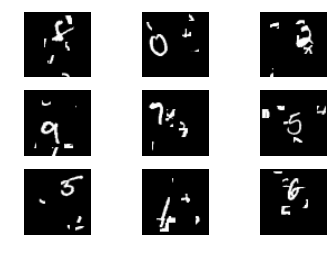

In [12]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Xaug[i, 0], cmap='gray')
    plt.axis('off')

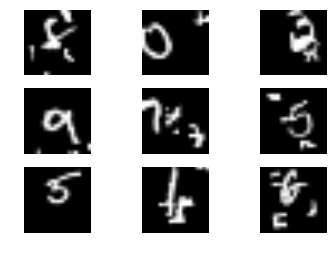

In [13]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Xresult[i, 0], cmap='gray')
    plt.axis('off')

In [14]:
wmat = model.get_weights()

model2 = Sequential()

model2.add(SpatialTransformer(localization_net=locnet,
                             downsample_factor=3, return_theta=True, input_shape=input_shape))

In [15]:
model2.compile(loss='mse',optimizer='sgd')

In [16]:
model2.set_weights(wmat[0:8])

In [17]:
out_array = model2.predict(X_train[:,:,:,:])

In [18]:
out_array.shape

(50000, 6)

In [19]:
width =60
height = 60
x_t, y_t = np.meshgrid(np.linspace(-1, 1, width), np.linspace(-1, 1, height))
ones = np.ones(np.prod(x_t.shape))
grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])

theta = out_array.reshape((50000, 2, 3))

T_g = np.dot(theta, grid)
T_g_clip = np.clip(T_g,-1,1)
x_s, y_s = T_g_clip[:, 0]+1, T_g_clip[:, 1]+1
x_s, y_s = x_s*width/2, y_s*height/2

In [20]:
np.amin(T_g)

-1.4075678177177906

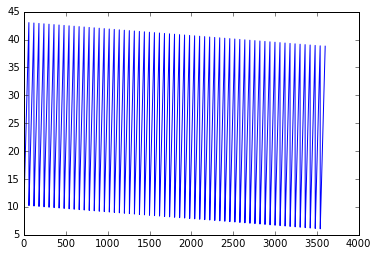

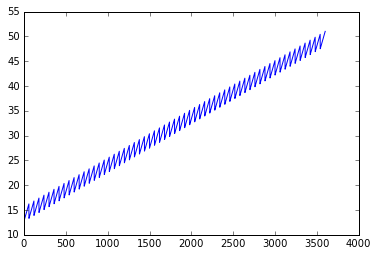

In [21]:
plt.plot(x_s[1,:])
plt.show()
plt.plot(y_s[1,:])
plt.show()

In [28]:
i=43512
print(x_s[i,0],y_s[i,0])
print(x_s[i,59],y_s[i,59])
print(x_s[i,-1],y_s[i,-1])
print(x_s[i,-60],y_s[i,-60])

18.1808131188 16.6505301744
48.9811842889 21.1791204661
44.532501027 56.4821159095
13.7321298569 51.9535256177


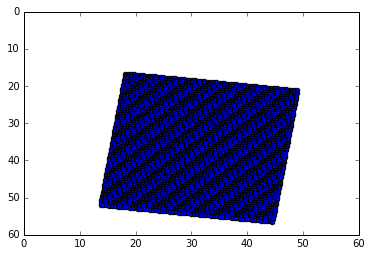

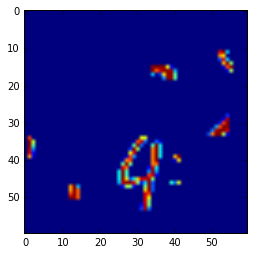

In [29]:
plt.scatter(x_s[i,:],y_s[i,:])
plt.axis((0,60,60,0))
plt.show()
plt.imshow(X_train[i,:,:,:].reshape(60,60))
plt.show()

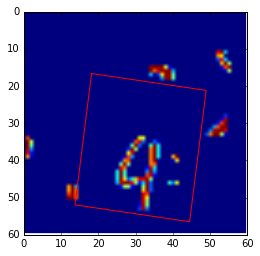

In [30]:
x_verts = (x_s[i,0],x_s[i,59],x_s[i,-1],x_s[i,-60],x_s[i,0])
y_verts = (y_s[i,0],y_s[i,59],y_s[i,-1],y_s[i,-60],y_s[i,0],)
plt.imshow(X_train[i,:,:,:].reshape(60,60))
plt.axis((0,60,60,0))
plt.plot(x_verts,y_verts,'r')